## Calculate balanced machine learning measures, Only Controol and Idiopathic Park, Without UPDRS, Just 1st analysis

From request [Run ML with and without UPDRS for Control vs. PD](https://trello.com/c/AjaQ5Q1N)

Weighted accuracy, ppv, npv, specificity, and sensitivity [See Sample Calculated Metrics](Machine_Learning_Metric_Calc.xlsx)

## Imports and Function Definitions

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [10]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
# Only control and idiopathic park
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx').drop(['UPDRS'], axis=1).loc[_data.GroupID <= 1]
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.6s finished


Best parameters set found on development set:

{'classifier__C': 2.06913808111479e-05}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.40      1.00      0.57        63
        1.0       0.00      0.00      0.00        95

avg / total       0.16      0.40      0.23       158


Confusion matrix, without normalization
[[63  0]
 [95  0]]

recall	0.0
precision	0.0
auc	0.5


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


specificity	1.0
npv	0.398734177215
accuracy	0.398734177215
weighted_sensitivity	0.0
weighted_ppv	nan
weighted_specificity	1.0
weighted_npv	0.5
weighted_accuracy	0.5


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in double_scalars


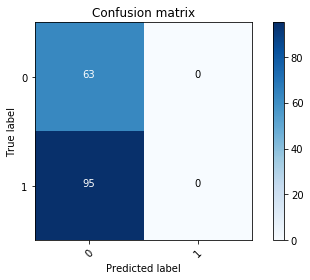

In [12]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [13]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\ana

fit_time	0.186464643478	0.00532237340954
score_time	0.110775709152	0.00534790089807
test_recall	1.0	0.0
train_recall	1.0	0.0
test_precision	0.659267591551	0.00107486564179
train_precision	0.659270784221	0.00027031274556
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	0.0	0.0
train_specificity	0.0	0.0
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.659267591551	0.00107486564179
train_accuracy	0.659270784221	0.00027031274556
test_weighted_sensitivity	1.0	0.0
train_weighted_sensitivity	1.0	0.0
test_weighted_ppv	0.5	0.0
train_weighted_ppv	0.5	0.0
test_weighted_specificity	0.0	0.0
train_weighted_specificity	0.0	0.0
test_weighted_npv	nan	nan
train_weighted_npv	nan	nan
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


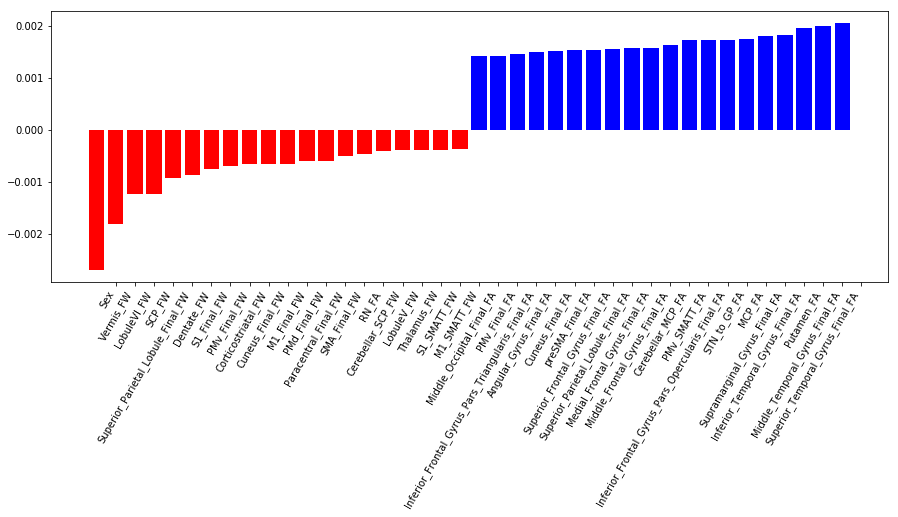

Age	-0.000137485829074
Sex	-0.00270359570934
aSN_FA	0.00116403649009
Caudate_FA	0.000236415045383
CC2_FA	0.00115529599658
GP_FA	0.00104850488415
LobuleVI_FA	0.000440196460389
LobuleV_FA	0.000461845925708
MCP_FA	0.00174934703856
pSN_FA	0.00106500511011
Putamen_FA	0.0019706619749
SCP_FA	0.00125603565117
STN_FA	0.00136573235574
Thalamus_FA	0.00140152451057
Vermis_FA	0.000253375172234
RN_FA	-0.000465424241572
PPN_FA	0.000895690168715
Dentate_FA	0.000685297358885
CC1_FA	0.000901338867731
aSN_FW	0.000473270352904
Caudate_FW	0.00100795316593
CC2_FW	6.42021010993e-05
GP_FW	0.000508926959227
LobuleVI_FW	-0.00123956777321
LobuleV_FW	-0.000396460107348
MCP_FW	0.000195390166758
pSN_FW	0.00135376070481
Putamen_FW	1.29444705977e-05
SCP_FW	-0.00123715087587
STN_FW	-2.36849784673e-05
Thalamus_FW	-0.000394888673843
Vermis_FW	-0.00181088981344
RN_FW	0.000542890634372
PPN_FW	-0.000183629096361
Dentate_FW	-0.000869533828126
CC1_FW	0.00028726295284
Angular_Gyrus_Final_FA	0.00149909578963
Anterior_Orbital_G

In [14]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.40      1.00      0.57        63
        1.0       0.00      0.00      0.00        95

avg / total       0.16      0.40      0.23       158



C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


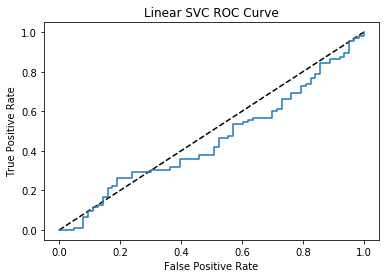

0.0 0.0
0.015873015873 0.0
0.047619047619 0.0
0.047619047619 0.0105263157895
0.0793650793651 0.0105263157895
0.0793650793651 0.0631578947368
0.0952380952381 0.0631578947368
0.0952380952381 0.0947368421053
0.111111111111 0.0947368421053
0.111111111111 0.115789473684
0.126984126984 0.115789473684
0.126984126984 0.126315789474
0.142857142857 0.126315789474
0.142857142857 0.168421052632
0.15873015873 0.168421052632
0.15873015873 0.210526315789
0.174603174603 0.210526315789
0.174603174603 0.221052631579
0.190476190476 0.221052631579
0.190476190476 0.263157894737
0.238095238095 0.263157894737
0.238095238095 0.294736842105
0.301587301587 0.294736842105
0.301587301587 0.305263157895
0.365079365079 0.305263157895
0.365079365079 0.315789473684
0.396825396825 0.315789473684
0.396825396825 0.357894736842
0.460317460317 0.357894736842
0.460317460317 0.378947368421
0.507936507937 0.378947368421
0.507936507937 0.421052631579
0.52380952381 0.421052631579
0.52380952381 0.463157894737
0.555555555556 0.4

In [15]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)